In [334]:
import Pkg; Pkg.add("LatinHypercubeSampling")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


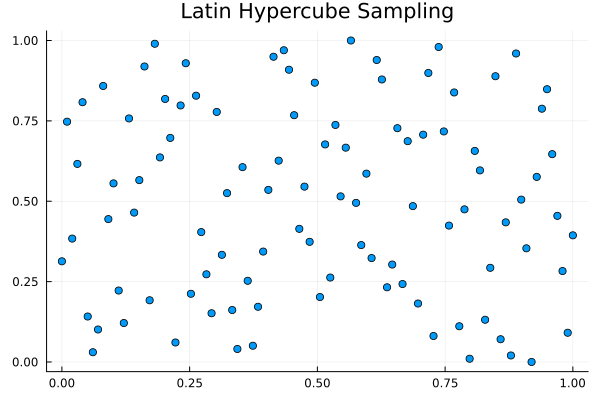

In [335]:
import LatinHypercubeSampling
plan, _ = LatinHypercubeSampling.LHCoptim(100, 2, 100)
scaled_plan = LatinHypercubeSampling.scaleLHC(plan, [(0, 1) for _ in 1:2])
plot(scaled_plan[:,1], scaled_plan[:,2], seriestype = :scatter, legend = false, title = "Latin Hypercube Sampling")

In [336]:
function sample_parameters_from_LHC(number_of_sets, number_of_parameters, gens)
    plan, _ = LatinHypercubeSampling.LHCoptim(number_of_sets, number_of_parameters, gens)
    params = LatinHypercubeSampling.scaleLHC(plan, [(0, 1) for _ in 1:number_of_parameters])
    return [params[i,:] for i in 1:number_of_sets]
end

sample_parameters_from_LHC (generic function with 1 method)

In [337]:
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")
eval(Meta.parse("@variables " * join([ifelse(i==3 && j==80, "", "ks_" * string(i) * "_" * string(j) *"(t), ") for i in 1:3 for j in 1:80]) * "ks_" * string(3) * "_" * string(80) * "(t)"))
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")

# --- GA parameters
genetic_pool_size = 300

death_rate = (rank) -> 0.0*(rank)
mutation_rate = (rank) -> (50/100)
gradient_mutation_rate = (rank) -> (1/100)*(1-rank)
duplication_rate = (rank) -> (1/100)*(1-rank)
crossover_rate = (rank) -> 0.0*(1-rank)
max_generations = 100
p_cross = 0.1

# --- GD parameters

# fixed, basic steps

N = 3
np = count_parameters(N)
target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
pars_l = assemble_opt_parameters_and_varables([0 for _ in 1:np], N) # just for the names
ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)
t0 = 10.0
t1 = 20.0

# set up gd problem 

crn_info = (
    crn = crn, 
    ode_crn = ode_crn,
    ext_ode = ext_ode,
    np = np,
    N = N,
    target = target
)

# set up the loss function

gd_loss_options = (
    weights = [10., 1., 1., 1], #[2.0, 1.0/3, 1.0/80, 100.0], #[1., 0.01, 0.01, 1.] # this descends smoothly
    p=0.05,
    d=0.5,
    f_ss=0.5,
    norm_for_sensitivity_loss = 1, 
    norm_for_ss_loss = 1,
    norm_for_adaptation_loss = 1,
    n_losses = 4
)

loss_blueprint = prepare_args(nothing, target, t0, t1, pars_l, gd_loss_options.weights, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss, gd_loss_options.norm_for_sensitivity_loss, gd_loss_options.norm_for_ss_loss, gd_loss_options.norm_for_adaptation_loss)

gd_options = (
    alpha = 0.1,
    n_iter = 10,
    use_pruning_heuristic = true,
    clip_value = nothing,
    use_gradient_normalization = true,
    use_adagrad = true, # overrides use_adam!
    use_adam = false,
    use_random_perturbation = false,
    verbose = false,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = compute_symbolic_derivatives_of_loss(total_loss_symbolic(loss_blueprint))
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    input = 1.,
    perturbation = 1.,
    K = 5,
    perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.],
    loss_blueprint = loss_blueprint
)


mutate_with_GD = (p) -> symbolic_gradient_descent(p, crn_info, gd_options, gd_perturbation_options, gd_loss_options).parameters
function make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, with_L1)
    function ev_loss(p)
        pars_l = assemble_opt_parameters_and_varables(p, crn_info.N)
        solutions = run_with_fixed_perturbations(crn_info.crn, p, pars_l, gd_perturbation_options.input,  gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1)
        losses = zeros(length(solutions))
        Threads.@threads for i in 1:length(solutions)
            loss_args = update_args(solutions[i], crn_info.target, gd_perturbation_options.t0, gd_perturbation_options.t1, pars_l, gd_perturbation_options.loss_blueprint, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss) 
            if with_L1
                losses[i] = total_loss_eval(loss_args).total.val
            else
                ev = total_loss_eval(loss_args)
                losses[i] = ev.total.val - ev.array[3].val
            end
        end
        return sum(losses)/length(gd_perturbation_options.perturbation_list)
    end
    return ev_loss
end
#loss_function_gd = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, true)
loss_function_ga = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options, false)
print("setup done!")

setup done!

In [338]:
reactions(crn)[30] # so we want to edit only parameter 29

k_29, x_3 --> ∅

In [339]:
output_degradation_parameter = 29
minimal_degradation_rate = 0.1

0.1

In [340]:
# println("Testing symbolic gradient descent")
# println(loss_function([1 for _ in 1:np]))
# test_p = symbolic_gradient_descent([1 for _ in 1:np], crn_info, gd_options, gd_perturbation_options, gd_loss_options)
# println(loss_function(test_p.parameters))

initialize the GA problem 

In [341]:
parameter_pool = sample_parameters_from_LHC(genetic_pool_size, np, 10) #[[rand() for _ in 1:np] for _ in 1:genetic_pool_size]
is_updated = [false for _ in 1:genetic_pool_size]
fitness = [0. for _ in 1:genetic_pool_size]

dp = 0.01

state = (pool = parameter_pool, is_updated = is_updated, fitness = fitness, history = (best_loss = [], mean_loss = []))
print("done")

done

In [342]:
using ProgressBars
max_generations = 500
for i in ProgressBar(1:max_generations)
    state = symbolic_evolve_NFB(crn, loss_function_ga, state, dp, genetic_pool_size, death_rate, mutation_rate, gradient_mutation_rate, mutate_with_GD, duplication_rate, crossover_rate, p_cross, output_degradation_parameter, minimal_degradation_rate)
end

0.0%┣                                              ┫ 0/500 [00:00<00:00, -0s/it]
0.2%┣                                          ┫ 1/500 [00:38<Inf:Inf, InfGs/it]
0.4%┣▏                                          ┫ 2/500 [01:21<11:16:12, 81s/it]
0.6%┣▎                                          ┫ 3/500 [02:00<08:16:46, 60s/it]
0.8%┣▍                                          ┫ 4/500 [02:35<07:07:56, 52s/it]
1.0%┣▍                                          ┫ 5/500 [03:11<06:33:31, 48s/it]
1.2%┣▌                                          ┫ 6/500 [03:54<06:25:17, 47s/it]
1.4%┣▋                                          ┫ 7/500 [04:32<06:12:05, 45s/it]
1.6%┣▊                                          ┫ 8/500 [05:15<06:08:59, 45s/it]
1.8%┣▊                                          ┫ 9/500 [05:56<06:04:20, 45s/it]
2.0%┣▉                                         ┫ 10/500 [06:35<05:58:30, 44s/it]
2.2%┣█                                         ┫ 11/500 [07:12<05:52:12, 43s/it]
2.4%┣█                      

In [343]:
minimum(state.history.mean_loss)

0.2175101044793443

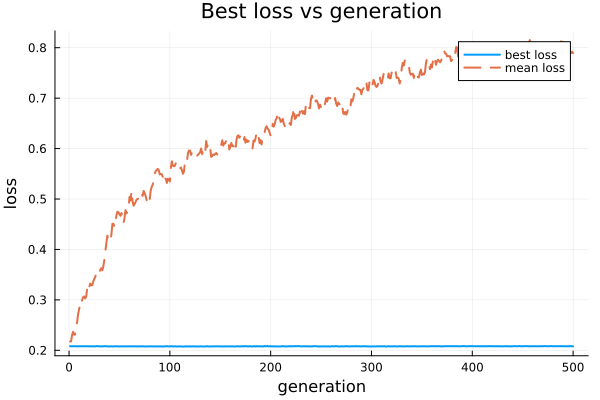

In [344]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

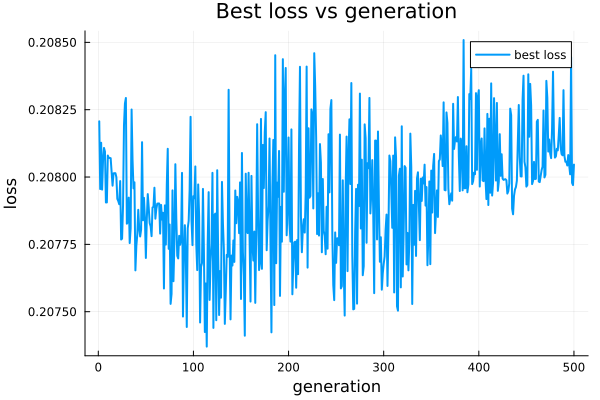

In [345]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)

In [346]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.20804618698776525


In [347]:
15
  56
  69
 110
 113
 139
 185
 232
 263

263

Optimal index: 94
Adaptation error: 0.05484589051980959
sensitivity: 0.050524937911009205 and  loss : 0.0405249379110092


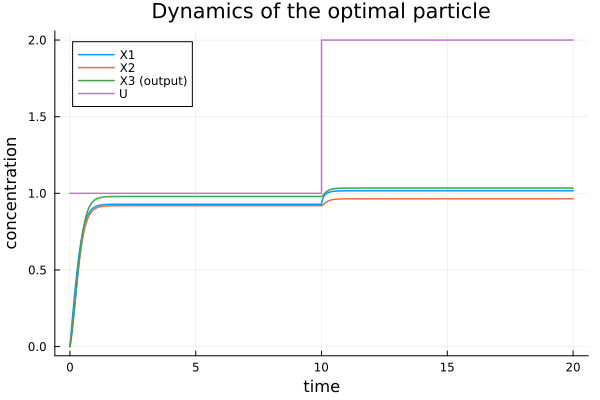

In [348]:
perturb = 1
opt_index = sortperm(state.fitness)[1]

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

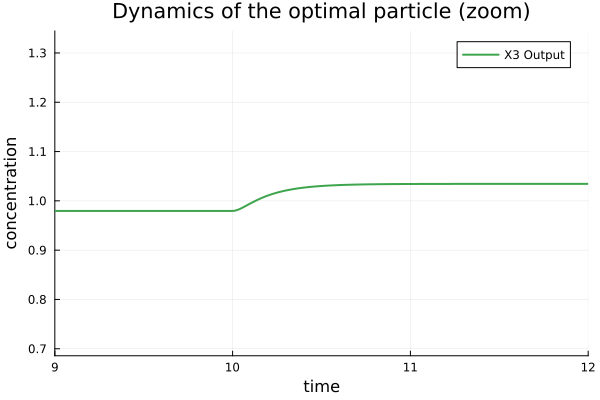

In [349]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [350]:
gd_options_for_output = (
    alpha = 1,# gd_options.alpha,
    n_iter = gd_options.n_iter,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)

(parameters = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], loss_tape = Any[1.1788710680931376, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527, 2.1315545540980527], loss_tape_array = Any[Num[0.08213920522950101, 3.4177964379021097e-11, 0.970849529867314, 0.12588233296214427], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.7692307692307694], Num[0.47619047619047616, 0.886133308676807, 0.0, 0.76923076923

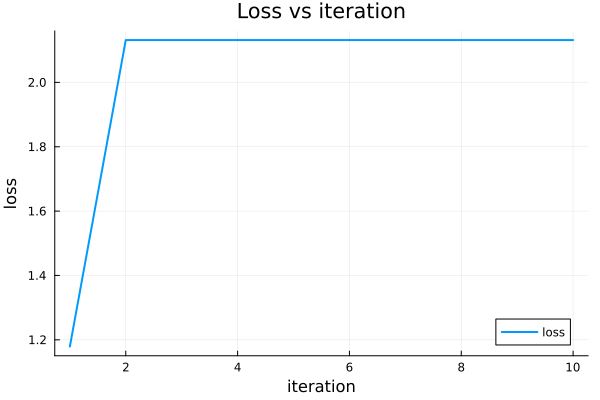

In [351]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

In [352]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = sortperm(state.fitness)[2]

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 2.5
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 4.327695636427939
A_32 = 3.3754512975922766
A_22 = -16.3374610857681
A_31 = 5.953323558173487
A_22*A_31 = -97.26219196264583
A_21*A_32 = 14.60792585156512
A_22*A_31 - A_21*A_32 = -111.87011781421094


In [353]:
homeostatic_coefs_A21_A32 = []
homeostatic_coefs_A22_A31 = []
homeostatic_coefs = []

for par_set in state.pool
    opt_pars_v = par_set
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

    jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

    perturb = 2.5
    steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
    steady_state_after_perturbation = [
        :x_1 => steady_state_after_perturbation[1],
        :x_2 => steady_state_after_perturbation[2],
        :x_3 => steady_state_after_perturbation[3]
    ]

    A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
    A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
    A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
    A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

    push!(homeostatic_coefs_A21_A32, A_21*A_32)
    push!(homeostatic_coefs_A22_A31, A_22*A_31)
    push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
end

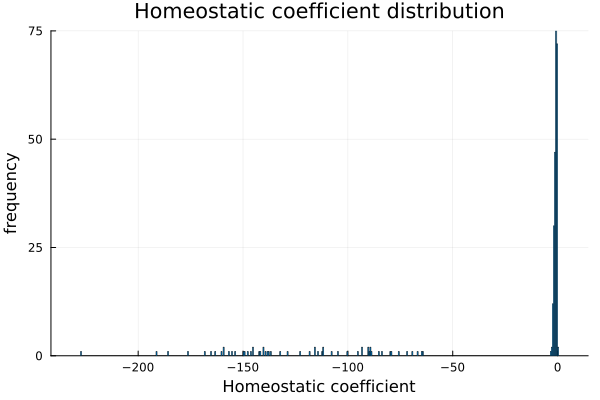

In [354]:
histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

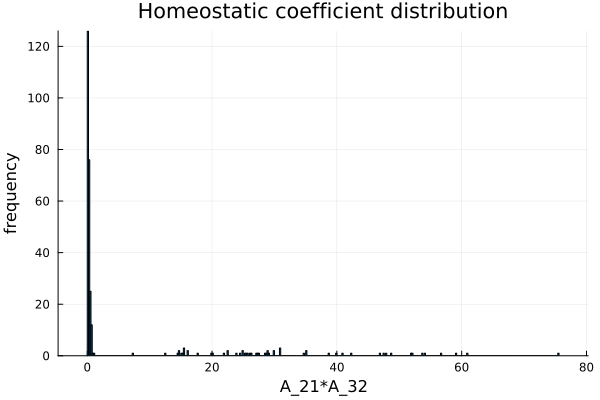

In [355]:
histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

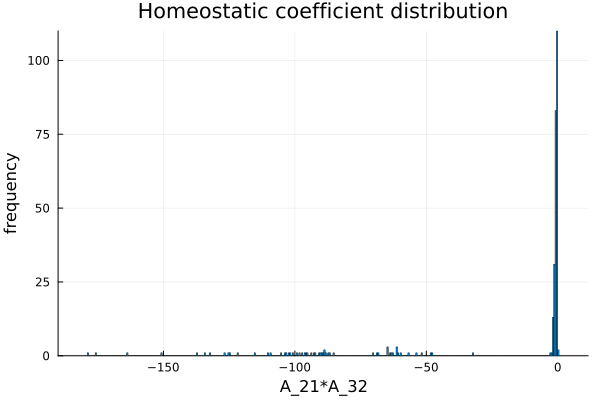

In [356]:
histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

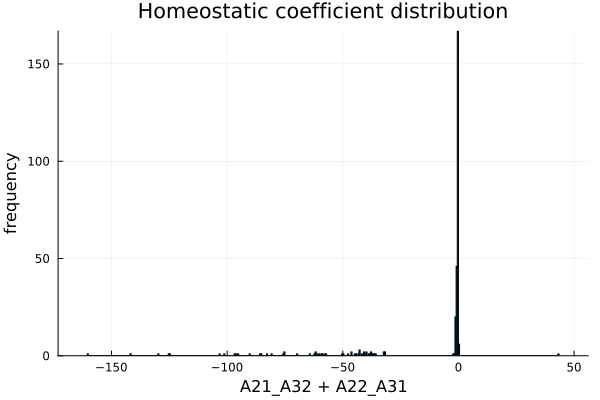

In [357]:
histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

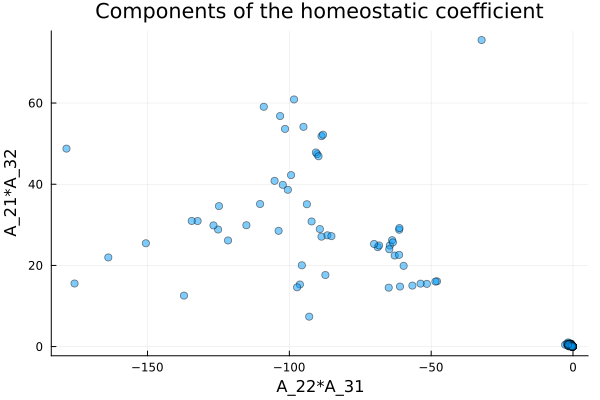

In [358]:
plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel="A_22*A_31", ylabel="A_21*A_32", title="Components of the homeostatic coefficient", lw=2, legend=false, alpha=0.5)

Adapting toplogies

In [359]:
findall(x -> -0.5 < x < 0.5, [x.val for x in homeostatic_coefs])

74-element Vector{Int64}:
   2
   3
   7
  10
  11
  17
  19
  20
  22
  30
  31
  32
  34
   ⋮
 226
 228
 234
 237
 239
 247
 249
 253
 257
 258
 269
 295

IFF

NFB

In [360]:
findall(x -> 0.01 < x < 0.1, (abs.([x.val for x in homeostatic_coefs_A22_A31]) + abs.([x.val for x in homeostatic_coefs_A21_A32]))/2  )

20-element Vector{Int64}:
   2
  20
  41
  42
  57
  70
  74
  86
  88
 102
 105
 107
 128
 198
 208
 226
 239
 247
 257
 269

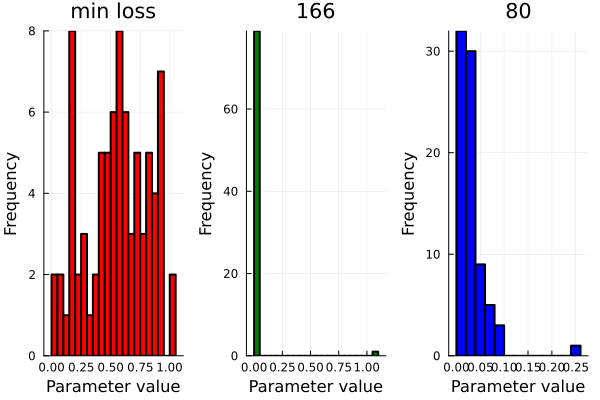

In [361]:

opt_index_options = [best, rand(1:length(state.pool)), 80]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "80"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

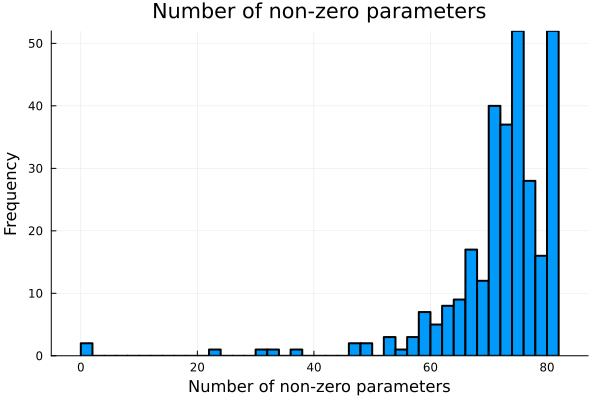

In [362]:
non_zero = []
for i in 1:length(state.fitness)
    push!(non_zero, sum(state.pool[i] .> 0.001))
end
histogram(non_zero, label=false, xlabel="Number of non-zero parameters", ylabel="Frequency", title="Number of non-zero parameters", lw=2, legend=false)

In [363]:
using JLD2

save_object("NFB-finding-run-240.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


In [364]:
using JLD2
test_load = load_object("/local0/scratch/git/SynthEvo/NFB-finding-run-240.jld2") 

Dict{String, Any} with 6 entries:
  "crn_info"                => (crn = ReactionSystem{NetworkProperties{Int64, B…
  "gd_perturbation_options" => (t0 = 10.0, t1 = 20.0, input = 1.0, perturbation…
  "state"                   => (pool = [[0.0156477, 0.0, 0.00243859, 0.0112246,…
  "ga_options"              => Dict{Any, Any}(#1455=>#1455, 300=>300, #1457=>#1…
  "gd_loss_options"         => (weights = [10.0, 1.0, 1.0, 1.0], p = 0.05, d = …
  "gd_options"              => (alpha = 0.1, n_iter = 10, use_pruning_heuristic…

In [365]:
test_load["state"].fitness

300-element Vector{Float64}:
 1.0467556758820995
 1.4735449676120744
 2.131554554098052
 0.8660985848929131
 0.6946983245815037
 0.7808346459230041
 1.2352432323688958
 0.7345190928940954
 0.8109741172812752
 1.0923438882022438
 1.0774679518226615
 0.6864499993391346
 1.012206831599917
 ⋮
 0.5624394810038418
 0.21407413218379712
 1.2696640574111548
 0.2162282022735642
 0.7633196950650557
 0.818684280422881
 0.9884340367025911
 0.6453923489539792
 0.21437710628161202
 0.2099267726854998
 0.2148154487543984
 0.21273497959769316

Index: 286
Adaptation error: 0.062093894307815756
sensitivity: 0.05445378859297789 and  loss : 0.04445378859297789
Loss: 0.20869841826542546


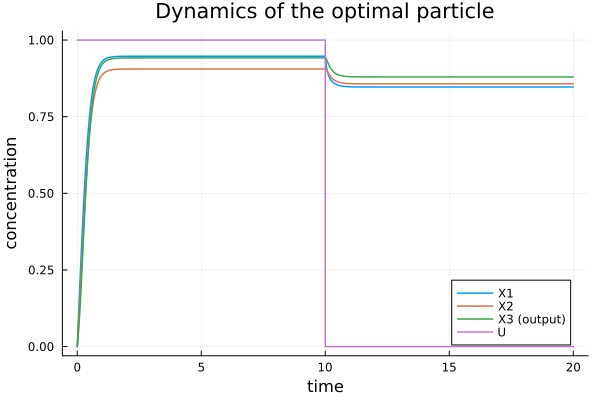

In [366]:
perturb = -1
opt_index =  sortperm(test_load["state"].fitness)[3]
#opt_index = 81

opt_pars_v = test_load["state"].pool[opt_index]
#opt_pars_v[29] = 1.0
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)


sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
println("Loss: ", test_load["state"].fitness[opt_index])
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

In [367]:
#opt_index = argmin(test_load["state"].fitness) 
ranks = reverse(sortperm(abs.(test_load["state"].pool[opt_index])))

for i in ranks
    if i != 1
        println(test_load["state"].pool[opt_index][i], " : ", reactions(crn)[2:end][i])
    end
end

0.9715288476355909 : k_41, x_1 + x_3 --> x_1
0.9630235517933302 : k_29, x_3 --> ∅
0.9615273171069214 : k_22, x_3 --> 2*x_1
0.9493697560904898 : k_47, x_2 + x_3 --> x_2
0.9429318523713137 : k_35, 2*x_3 --> ∅
0.9346741716880311 : k_13, x_1 --> x_1 + x_3
0.9103647226691273 : k_54, 2*x_1 --> x_2 + x_3
0.9051020685811354 : k_44, 2*x_2 --> x_1
0.8911278390905636 : k_61, x_1 + x_3 --> 2*x_1
0.8811449459004574 : k_15, x_1 --> x_2 + x_3
0.8605476094629112 : k_8, x_2 --> x_1
0.847835401350008 : k_43, x_1 + x_3 --> x_3
0.8398357023546793 : k_3, ∅ --> x_1 + x_2
0.8316135271251427 : k_25, x_3 --> 2*x_2
0.8208128022616654 : k_11, x_3 --> x_2
0.8105398917658664 : k_49, 2*x_3 --> x_1
0.7911495057281369 : k_40, x_1 + x_2 --> x_3
0.7871050583638429 : k_27, x_1 --> ∅
0.7778894472102402 : k_68, 2*x_2 --> x_1 + x_3
0.7614822495793991 : k_6, x_1 --> x_2
0.7581092962908885 : k_48, x_2 + x_3 --> x_3
0.7572199918358835 : k_7, x_1 --> x_3
0.753092929534852 : k_10, x_3 --> x_1
0.7504881799120864 : k_16, x_1 --> 